In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import plotnine as p9

%matplotlib inline

In [2]:
# based on UMich Consumer Sentiment survey history
YEARS_EXPECTED = (2025 - 1978) + 1
# follows from monthly frequency.
# latter term depends on precise extraction timing
OBSERVATIONS_EXPECTED = (YEARS_EXPECTED - 1) * 12 + 2
# from inspection
INDICATORS_COMPLETE_HISTORY = 150

US_RECESSION_PRB_BASELINE = 0.1

In [3]:
# load UMich Consumer Sentiment time series, 1978-
    # select which indicators for consideration?
    # create dataframe index from time
    # test data expectations:
        # unique on month
        # observation count roughly 12 * (2025-1978)
        # all fields have numeric type
        # no nulls
        # big picture, headline Consumer Sentiment index roughly tracks with recessions' timing
readings = (
    # download source: https://data.sca.isr.umich.edu/data-archive/mine.php
    pd.read_csv("./data/external/sca-tableall-on-2025-Mar-25.csv", skiprows=1)
    .rename(columns={'yyyy': 'year'})
    )
readings.columns = [x.lower() for x in readings.columns]
assert readings['year'].nunique() == YEARS_EXPECTED
assert readings.shape[0] == OBSERVATIONS_EXPECTED

assert readings[['year', 'month']].notnull().all().all()
readings = (
    readings
    .assign(day = 1)
    .assign(time_index = lambda df_: pd.to_datetime(df_[['year', 'month', 'day']]))
    .set_index('time_index')
    .drop(columns=['month', 'year'])
)
assert readings.index.is_unique

readings.dtypes.value_counts()

# how might incomplete time series be leveraged?
is_column_complete = (readings.isnull().mean() == 0).to_dict()
is_column_complete = [x for x, is_complete in is_column_complete.items() if is_complete]
readings = readings[is_column_complete]
assert readings.notnull().all().all()
assert np.isclose(readings.shape[1], INDICATORS_COMPLETE_HISTORY, rtol=0.05)

In [4]:
pd.Series(readings.index).describe()

count                              566
mean     2001-07-16 18:31:48.127208448
min                1978-01-01 00:00:00
25%                1989-10-08 18:00:00
50%                2001-07-16 12:00:00
75%                2013-04-23 12:00:00
max                2025-02-01 00:00:00
Name: time_index, dtype: object

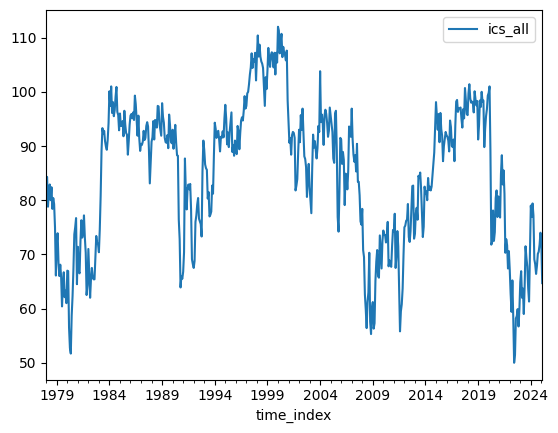

In [5]:
# helpful official visual to compare to: http://www.sca.isr.umich.edu/charts.html
readings[['ics_all']].plot.line();

In [6]:
# load NBER is_recession time series, 1978- (expect 6 recessions)
    # create dataframe index from time
    # test data expectations:
        # unique on month
        # observation count
        # all fields numeric type
        # valid values are 0 & 1. Average recession length? Total months in recession? 
        # no nulls
        # plot aligns with expectation
indicators_recession = (
    # download source: https://fred.stlouisfed.org/series/USREC
    pd.read_csv("./data/external/USREC.csv")
    .assign(observation_date = lambda df_: pd.to_datetime(df_['observation_date']))
    .set_index('observation_date')
)
indicators_recession.columns = [x.lower() for x in indicators_recession.columns]
assert indicators_recession.index.is_unique
assert indicators_recession.shape[0] == OBSERVATIONS_EXPECTED

assert indicators_recession.notnull().all().all()

assert np.isclose(indicators_recession['usrec'].mean(), US_RECESSION_PRB_BASELINE, atol=0.05)

# transform is_recession_next_12_months (y)
    # test average, and by decade
indicators_recession = (
    indicators_recession
    .assign(
        # for forward-looking measure: compute backward-looking max via `rolling`, then shift that backward
        is_recession_in_next_12_months = lambda df_: df_['usrec'].rolling(window=12, min_periods=6).max().shift(-12)
        )
)

# assumption: when more recent data lack next-12-months observation, they're uninformative
# indicators_recession.isnull().mean()
indicators_recession = indicators_recession.dropna()

indicators_recession.mean()

# indicators_recession.to_csv("./data/processed/usrec_transformed.csv")

# indicators_recession.shift(-10).head(25)

usrec                             0.104693
is_recession_in_next_12_months    0.223827
dtype: float64

In [7]:
pd.Series(indicators_recession.index).describe()

count                              554
mean     2001-01-15 03:20:08.664259968
min                1978-01-01 00:00:00
25%                1989-07-08 18:00:00
50%                2001-01-16 12:00:00
75%                2012-07-24 06:00:00
max                2024-02-01 00:00:00
Name: observation_date, dtype: object

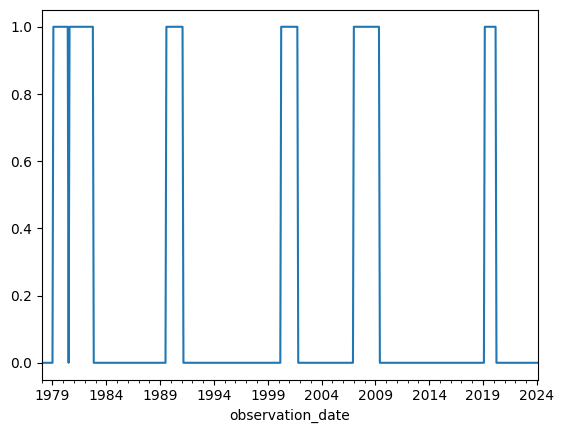

In [8]:
indicators_recession['is_recession_in_next_12_months'].plot.line();

In [9]:
# integrate on time spine
    # ensure no nulls
XY = readings.join(indicators_recession[['usrec', 'is_recession_in_next_12_months']], how='left')
assert XY.shape[0] == OBSERVATIONS_EXPECTED

XY = (
    XY
    .assign(is_recession_in_next_12_months_label = lambda df_: df_['is_recession_in_next_12_months'].map({0: '(1) No Recession in Next 12 Months', 1: '(2) Yes, Recession in Next 12 Months'}).fillna('(3) Unknown, Too Recent'))
)

# more recent observations haven't seen 12 months ahead
XY_complete_cases = XY.dropna(subset='is_recession_in_next_12_months')

pd.Series(XY.index).describe(), pd.Series(XY_complete_cases.index).describe()

(count                              566
 mean     2001-07-16 18:31:48.127208448
 min                1978-01-01 00:00:00
 25%                1989-10-08 18:00:00
 50%                2001-07-16 12:00:00
 75%                2013-04-23 12:00:00
 max                2025-02-01 00:00:00
 Name: time_index, dtype: object,
 count                              554
 mean     2001-01-15 03:20:08.664259968
 min                1978-01-01 00:00:00
 25%                1989-07-08 18:00:00
 50%                2001-01-16 12:00:00
 75%                2012-07-24 06:00:00
 max                2024-02-01 00:00:00
 Name: time_index, dtype: object)

In [10]:
# summarize pairwise (y-indicator): Mutual Information (MI)
# `classification` variant used when target is discrete.
# source: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

X = XY_complete_cases.drop(columns=['usrec', 'is_recession_in_next_12_months', 'is_recession_in_next_12_months_label'])
y = XY_complete_cases['is_recession_in_next_12_months']

indicators_mutual_information = pd.Series(mutual_info_classif(X, y), index=X.columns).sort_values(ascending=False)

# plot highest MI pairs -- distribution of X, by y

In [11]:
indicators_mutual_information

newsrn_f_emp_all    0.172865
news_f_all          0.156908
umex_r_all          0.151757
veh_r_all           0.150336
btrd_bb_all         0.148453
                      ...   
pagorn_ld_all       0.000000
pagorn_ny_all       0.000000
govt_r_all          0.000000
dur_s_all           0.000000
umex_dk_all         0.000000
Length: 150, dtype: float64

/Users/alexabraham/anaconda3/envs/learning_to_price_assets/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 23'. Pick better value with 'binwidth'.


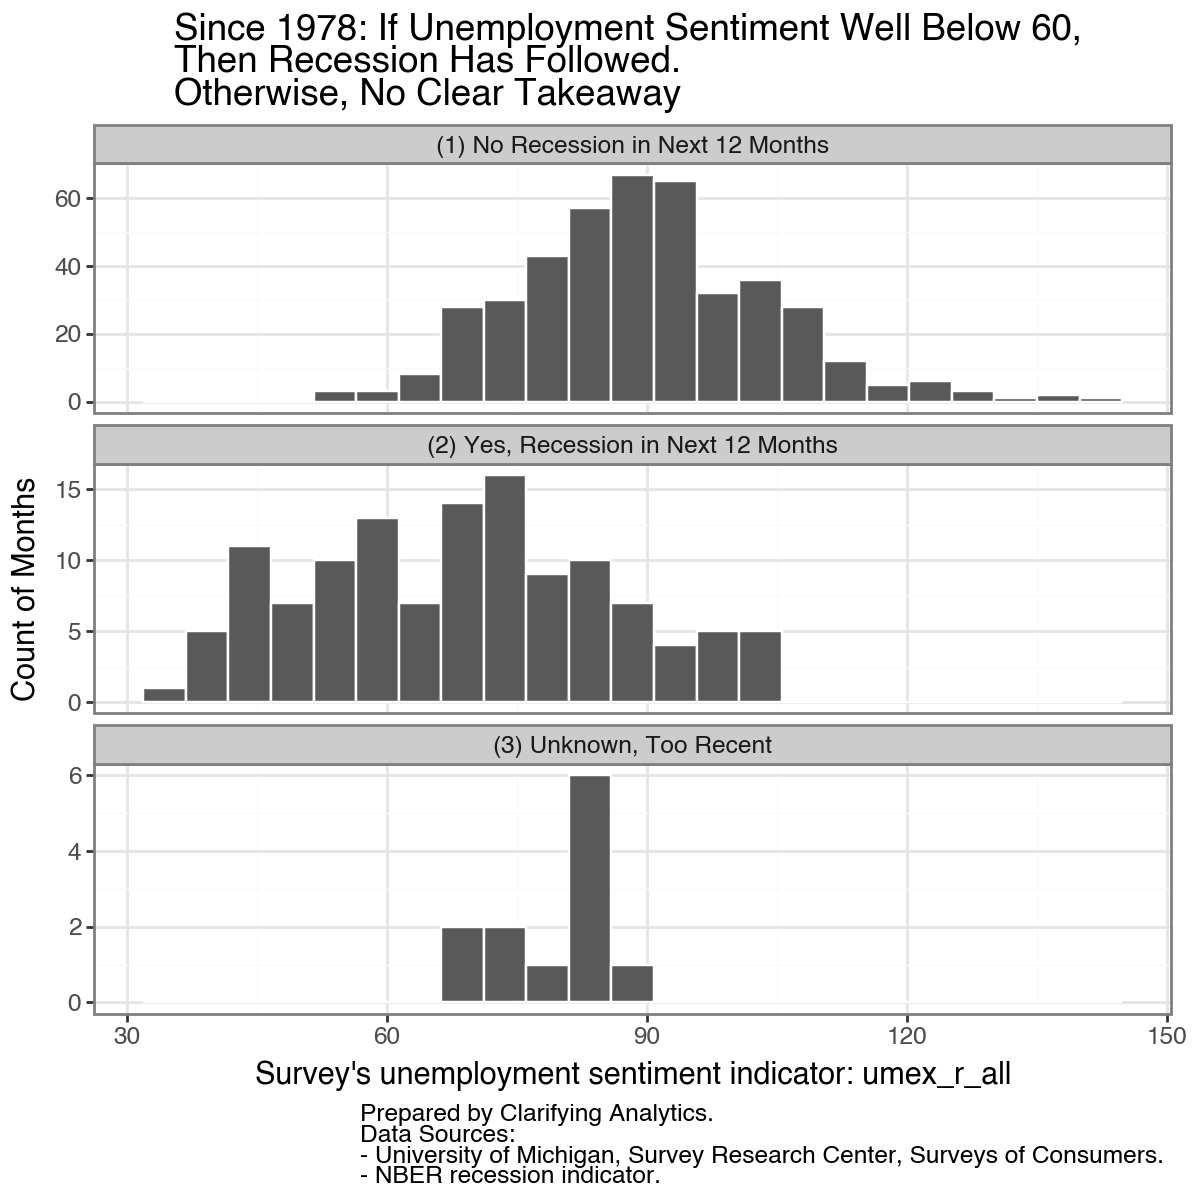

In [12]:
(
    p9.ggplot(XY) + 
    p9.theme_bw() + 
    p9.geom_histogram(p9.aes('umex_r_all'), color='white') + 
    p9.facet_wrap('is_recession_in_next_12_months_label', ncol=1, scales='free_y') + 
    # p9.geom_vline(xintercept=100, linetype='dashed') + 
    p9.labs(
        y="Count of Months", 
        x="Survey's unemployment sentiment indicator: umex_r_all", 
        title="Since 1978: If Unemployment Sentiment Well Below 60, \nThen Recession Has Followed. \nOtherwise, No Clear Takeaway",
        # per https://data.sca.isr.umich.edu/faq.php
        caption="Prepared by Clarifying Analytics. \nData Sources: \n- University of Michigan, Survey Research Center, Surveys of Consumers. \n- NBER recession indicator."
        ) + 
    p9.theme(figure_size=(6,6))
)

In [13]:
XY_complete_cases['umex_r_all'].describe()

count    554.000000
mean      84.927798
std       17.395990
min       33.000000
25%       75.000000
50%       86.000000
75%       95.000000
max      141.000000
Name: umex_r_all, dtype: float64

In [14]:
(
    XY_complete_cases
    # this particular indicator arrives in whole numbers
    .assign(umex_r_all_bucket = lambda df_: pd.cut(df_['umex_r_all'], [30, 60, 75, 85, 95, 150], include_lowest=True, precision=0))
    .groupby('umex_r_all_bucket', dropna=False)
    ['is_recession_in_next_12_months']
    .agg(['size', 'mean'])
    .round(2)
    .rename(columns={'size': 'data_points', 'mean': 'recession_next_12_months_avg_rate'})
    # .to_csv("./data/processed/recession_next_12_months_rate_by_umex_r_all.csv")
)

/var/folders/dy/d1fr00rn69q5d_2d38153xw00000gn/T/ipykernel_47359/2684965113.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,data_points,recession_next_12_months_avg_rate
umex_r_all_bucket,,
"(29, 60]",48,0.90
"(60, 75]",99,0.38
"(75, 85]",128,0.17
"(85, 95]",143,0.08
"(95, 150]",136,0.07


In [15]:
XY = XY.assign(usrec_bar = lambda df_: df_['usrec'] * 1_000)

# tricky to combine proper ylim with recession bars.
# easier to customize plot with Excel
# XY[['umex_r_all', 'usrec', 'usrec_bar']].to_csv("./data/processed/readings_usrec.csv")

# (
#     p9.ggplot(XY.reset_index(drop=False)) + 
#     p9.theme_bw() + 
#     p9.geom_col(p9.aes('time_index', 'usrec_bar'), color='grey') +
#     # p9.ylim(0, 145) +  
#     p9.geom_line(p9.aes('time_index', 'umex_r_all'))
# )

/Users/alexabraham/anaconda3/envs/learning_to_price_assets/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.


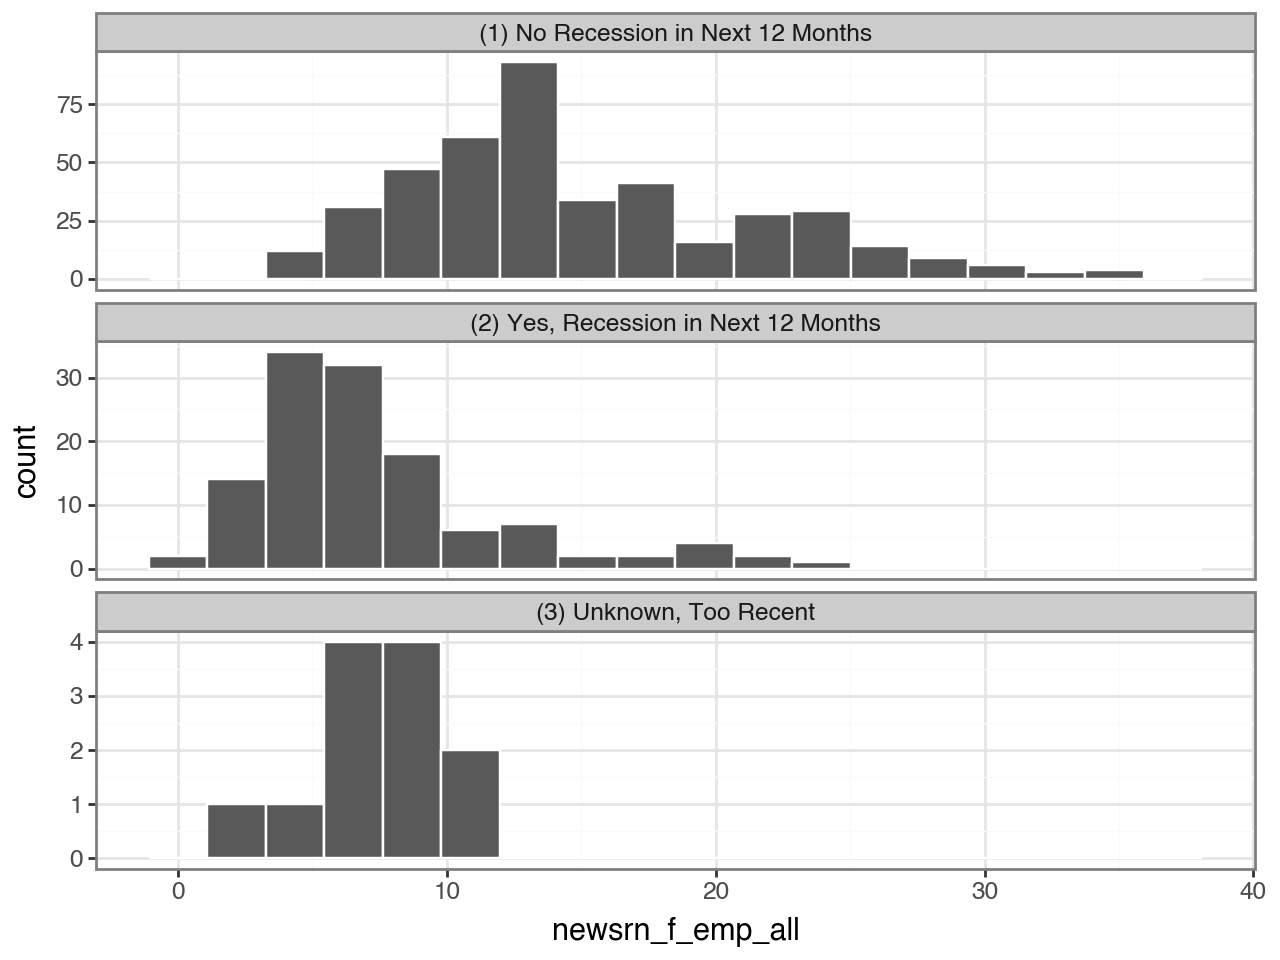

In [16]:
(
    p9.ggplot(XY) + 
    p9.theme_bw() + 
    p9.geom_histogram(p9.aes('newsrn_f_emp_all'), color='white') + 
    p9.facet_wrap('is_recession_in_next_12_months_label', ncol=1, scales='free_y')
)

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Test Expectation of Mutual Information Behavior

In [ ]:
# test of method's behavior: 
# for nonlinear relationships, MI rises relative to correlation coefficient.
# reference -- Machine Learning: A Probabilistic Perspective (Ch 2), Murphy
X = pd.DataFrame(np.random.normal(size=(100, 4)), columns=['x0', 'x1', 'x2', 'x3'])
X_transform = (
    X
    .assign(
        x3_pow2 = lambda df_: df_['x3']**2, 
        x3_pow3 = lambda df_: df_['x3']**3
        )
)
beta = np.array([1, 0, 0, 3, -2, -1])
epsilon = np.random.normal(scale=0.1, size=100)
y = X_transform @ beta + epsilon
XY = X.copy().assign(y=y)

In [ ]:
# test expected relationship
(
    p9.ggplot(XY) + 
    p9.theme_bw() + 
    p9.geom_point(p9.aes('x3', 'y'))
)

In [ ]:
mutual_info_regression(X, y)

In [ ]:
XY.corr()